In [1]:
import pandas as pd
import os
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import numpy as np
import joblib
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
%matplotlib inline
import sys

sys.path.append('..')
from helpers.readers import read_dataframe

DATA_PATH = '../generated/annotations_2023/'

### How to get the data
1. Download from [here](https://drive.google.com/drive/folders/1pSyWy1uQqbTe4xCt9TtvIQM0YTyVZ8Tr?usp=drive_link) `tokens.parquet`, `dependencies.parquet` and `entities.parquet` (generated from [`Text to Dataframes (2023).ipnyb`](https://github.com/epfl-ada/ada-2023-project-crunchychicken/blob/main/pipelines/Text%20to%20Dataframes%20(2023).ipynb))
2. Place the files inside `annotations_2023/`:
```
project_root/
│
├── P2.ipynb
│
├── generated/
│   ├── annotations_2023/
```

In [2]:
tokens = read_dataframe('cmu/tokens_2023')
dependencies = read_dataframe('cmu/dependencies_2023')
entities = read_dataframe('cmu/entities_2023')
# coreference is complex to integrate, for now we will use these three dataframes

In [3]:
tokens['token_id'] = tokens.groupby(['Wikipedia_movie_id', 'Sentence_id']).cumcount() + 1 # adding token id, not present by default in 4.5.5
tokens = tokens.drop(['Sentiment', 'COB', 'COE'], axis=1) # can use Sentiment later

In [4]:
# 15M            15M                 2.2M
len(tokens), len(dependencies), len(entities)

(15046378, 15376339, 2220379)

### Preprocessing
Running on such big dataframes will take too much time. To solve this, we will first filter on movie plots that contain a character (from the entities dataframe check for `Entity_type == PERSON` and a non NaN `Optional_probability`) and on also filter on the dependencies (from the dependencies dataframe check that the `Dependency_type` satisfies an agent verb, patient verb or attribute).

In [5]:
%%time
agent_verbs = ["agent", "nsubj"]
patient_verbs = ["dobj", "nsubjpass", "iobj"] # no prep_ using coreNLP4.5.5
attributes_av = ["nsubj", "appos"]
attributes_pv = ["nsubj", "appos", "amod", "nn"]

def is_matching_dependency(dep_type):
    if dep_type in agent_verbs or dep_type in patient_verbs or dep_type in attributes_av or dep_type in attributes_pv:
        return True
    else: return False

tokens_with_character = tokens[tokens["NER"] == "PERSON"]["Wikipedia_movie_id"].tolist()
entities_with_character = entities[(entities['Entity_type'] == 'PERSON') & (entities['Optional_probability'].notna())]["Wikipedia_movie_id"].tolist()
prefiltered_entities = entities[(entities['Entity_type'] == 'PERSON') & (entities['Optional_probability'].notna())].copy()
dependencies_with_dep = dependencies[dependencies['Dependency_type'].apply(is_matching_dependency)]["Wikipedia_movie_id"].tolist()
prefiltered_dependencies = dependencies[dependencies['Dependency_type'].apply(is_matching_dependency)].copy()

set_tokens = set(tokens_with_character)
set_entities = set(entities_with_character)
set_dependencies = set(dependencies_with_dep)

intersection_set = set_tokens & set_entities & set_dependencies

filtered_tokens = tokens[tokens["Wikipedia_movie_id"].isin(intersection_set)]
filtered_entities = prefiltered_entities[prefiltered_entities["Wikipedia_movie_id"].isin(intersection_set)]
filtered_dependencies = prefiltered_dependencies[prefiltered_dependencies["Wikipedia_movie_id"].isin(intersection_set)]

CPU times: total: 19.4 s
Wall time: 20 s


In [6]:
len(filtered_tokens), len(filtered_dependencies), len(filtered_entities)

(14714763, 3603836, 848088)

In [7]:
%%time
word_to_character = {}
for _, row in filtered_entities.iterrows():
    character_name = row['Word']
    movie_id = row['Wikipedia_movie_id']
    sentence_id = row['Sentence_id']
    for word in character_name.split():
        key = (movie_id, sentence_id, word)
        word_to_character[key] = character_name

filtered_tokens_copy = filtered_tokens.copy()

def map_word_to_character(row):
    key = (row['Wikipedia_movie_id'], row['Sentence_id'], row['Word'])
    return word_to_character.get(key, '')

filtered_tokens_copy['Character'] = filtered_tokens_copy.apply(map_word_to_character, axis=1)

CPU times: total: 3min 22s
Wall time: 3min 25s


In [8]:
%%time
merge1 = pd.merge(filtered_tokens_copy, filtered_dependencies, left_on=['Wikipedia_movie_id', 'Sentence_id', 'token_id'], right_on=['Wikipedia_movie_id', 'Sentence_id', 'Word_1_idx'])

merge2 = pd.merge(filtered_tokens_copy, filtered_dependencies, left_on=['Wikipedia_movie_id', 'Sentence_id', 'token_id'], right_on=['Wikipedia_movie_id', 'Sentence_id', 'Word_2_idx'])

final_merged_df = pd.concat([merge1, merge2], ignore_index=True)

CPU times: total: 27.5 s
Wall time: 27.9 s


In [9]:
final_merged_df

,Wikipedia_movie_id,Sentence_id,Word,POS,Lemma,NER,token_id,Character,Dependency_type,Word_1,Word_1_idx,Word_2,Word_2_idx
0,11784534,1,Bergman,NNP,Bergman,PERSON,7,Ingrid Bergman,nn,Bergman,7,Ingrid,6
1,11784534,1,Sanders,NNP,Sanders,PERSON,10,George Sanders,nn,Sanders,10,George,9
2,11784534,1,couple,NN,couple,O,15,,nsubj,couple,15,Joyces,2
3,11784534,1,couple,NN,couple,O,15,,amod,couple,15,English,14
4,11784534,1,gone,VBN,go,O,18,,nsubj,gone,18,who,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207667,9990262,48,min,NNP,min,O,10,,nsubj,asks,12,min,10
7207668,9990262,48,min,NNP,min,O,10,,nsubj,get,14,min,10
7207669,9990262,48,head,NN,head,O,16,,nn,surgery,22,head,16
7207670,9990262,48,toe,NN,toe,O,20,,nn,plastic,21,toe,20


In [10]:
# !pip install memory_profiler
# install and load memory_profiler to use %memit, use %whos to see what's in memory
%load_ext memory_profiler
%memit
import gc

del filtered_entities
del filtered_tokens_copy
del filtered_dependencies
del filtered_tokens
del dependencies
del dependencies_with_dep
del entities
del entities_with_character
del intersection_set
del merge1
del merge2 
del prefiltered_dependencies
del prefiltered_entities
del set_dependencies        
del set_entities              
del set_tokens
del tokens
del tokens_with_character

gc.collect()
%memit

peak memory: 10949.94 MiB, increment: 0.04 MiB
peak memory: 6863.02 MiB, increment: 0.00 MiB


### Adding the POS and lemma of dependencies to the merged dataframe before running extractor

In [ ]:
def get_dependency_pos_lemma(row):
    if row['Character']:
        dependency_idx = row['Word_2_idx'] if row['Word'] == row['Word_1'] else row['Word_1_idx']

        pos_lemma = final_merged_df.loc[(final_merged_df['Wikipedia_movie_id'] == row['Wikipedia_movie_id']) &
                                        (final_merged_df['Sentence_id'] == row['Sentence_id']) &
                                        (final_merged_df['token_id'] == dependency_idx), ['POS', 'Lemma']].iloc[0]
        return pos_lemma.POS, pos_lemma.Lemma
    return '', ''

Will take around 2 hours 👇

In [ ]:
%%time
def process_chunk(chunk):
    return chunk.apply(get_dependency_pos_lemma, axis=1)

num_partitions = joblib.cpu_count()
chunk_size = int(np.ceil(final_merged_df.shape[0] / num_partitions))
chunks = [final_merged_df.iloc[i:i + chunk_size] for i in range(0, final_merged_df.shape[0], chunk_size)]

results = Parallel(n_jobs=num_partitions)(delayed(process_chunk)(chunk) for chunk in chunks)

pos_lemma_df = pd.concat(results, ignore_index=True)

final_merged_df = pd.concat([final_merged_df.reset_index(drop=True), pos_lemma_df], axis=1)

final_merged_df_filtered = final_merged_df[final_merged_df['Character'] != '']

In [ ]:
final_merged_df_filtered = final_merged_df_filtered.copy()

final_merged_df_filtered.loc[:, 'Dependency_POS'] = final_merged_df_filtered[0].apply(lambda x: x[0])
final_merged_df_filtered.loc[:, 'Dependency_Lemma'] = final_merged_df_filtered[0].apply(lambda x: x[1])

final_merged_df_filtered = final_merged_df_filtered.drop(columns=[0])

final_merged_df_filtered

In [ ]:
del results
del pos_lemma_df
del final_merged_df
gc.collect()

In [ ]:
final_merged_df_filtered

### Extractor

In [ ]:
characters = pd.DataFrame(columns=['Wikipedia_movie_id', 'Character', 'AV', 'PV', 'Att']) # dataframe where we will store the character, its actions (agent and patient) and attributes
verb_pos_tags = ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"] # to indentify verbs from attributes

In [ ]:
%%time
def process_chunk(chunk):
    temp_data = defaultdict(lambda: {'AV': [], 'PV': [], 'Att': []})
    for _, row in chunk.iterrows():
        result = process_row(row)
        key = (result['Wikipedia_movie_id'], result['Character'])
        temp_data[key]['AV'].extend(result['AV'])
        temp_data[key]['PV'].extend(result['PV'])
        temp_data[key]['Att'].extend(result['Att'])
    return temp_data

num_partitions = joblib.cpu_count()
chunk_size = int(np.ceil(final_merged_df_filtered.shape[0] / num_partitions))
chunks = [final_merged_df_filtered.iloc[i:i + chunk_size] for i in range(0, final_merged_df_filtered.shape[0], chunk_size)]

chunk_results = Parallel(n_jobs=num_partitions)(delayed(process_chunk)(chunk) for chunk in chunks)

combined_results = defaultdict(lambda: {'AV': [], 'PV': [], 'Att': []})
for chunk_result in chunk_results:
    for key, values in chunk_result.items():
        combined_results[key]['AV'].extend(values['AV'])
        combined_results[key]['PV'].extend(values['PV'])
        combined_results[key]['Att'].extend(values['Att'])

character_data = []
for (movie_id, character), values in combined_results.items():
    character_data.append({
        'Wikipedia_movie_id': movie_id,
        'Character': character,
        'AV': values['AV'],
        'PV': values['PV'],
        'Att': values['Att']
    })

characters = pd.DataFrame(character_data)

In [ ]:
characters.to_parquet(os.path.join(DATA_PATH, "characters.parquet"), compression= "brotli")

In [ ]:
characters

### Generate bag of words
A bag is a tupple of $(r,w)$, where $r$ is of {agent verb, patient verb, attribute} and $w$ is the lemma of the word.

In [ ]:
def generate_bags_of_words(characters_df: pd.DataFrame):
    bags_of_words = []

    for _, row in tqdm(characters_df.iterrows()):
        movie_id = row['Wikipedia_movie_id']
        character_name = row['Character']

        av = row['AV'] if isinstance(row['AV'], list) else []
        pv = row['PV'] if isinstance(row['PV'], list) else []
        att = row['Att'] if isinstance(row['Att'], list) else []

        for verb in av:
            bags_of_words.append((movie_id, character_name, 'agent_verb', verb))

        for verb in pv:
            bags_of_words.append((movie_id, character_name, 'patient_verb', verb))

        for attribute in att:
            bags_of_words.append((movie_id, character_name, 'attribute', attribute))

    return bags_of_words

bags_of_words = generate_bags_of_words(characters)

In [ ]:
bags_df = pd.DataFrame(bags_of_words, columns=['movie_id', 'character_name', 'type', 'word'])
bags_df.to_parquet(os.path.join(DATA_PATH, "bags.parquet"), compression= "brotli")

### From tupples to topics using LDA

In [5]:
bags_df = read_dataframe('cmu/bags_2023')
bags_of_words=bags_df.values

bags_df.head(3)

,movie_id,character_name,type,word
0,11784534,Ingrid Bergman,attribute,Ingrid
1,11784534,Ingrid Bergman,attribute,Bergman
2,11784534,George Sanders,attribute,George


<span style="color:red;">Update part compared to "Annotations to Personas (2023).ipynb"</span>

In [13]:
# Make a distinction of the same character name in different movies by adding the movie id to the character name, ex. movie_id_character_name
character_docs = defaultdict(list)
for movie_id, character, _, word in bags_of_words:
    character_docs[str(movie_id)+'_'+str(character)].append(word)

for character in character_docs:
    character_docs[character] = " ".join(character_docs[character])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(character_docs.values())

n_topics = 50
lda = LatentDirichletAllocation(n_components=n_topics, verbose=2, max_iter=10, random_state = 0)
lda.fit(X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 6 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 10 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s finished


LatentDirichletAllocation(n_components=50, random_state=0, verbose=2)

In [14]:
joblib.dump(lda, os.path.join(DATA_PATH, "lda_model_update.gz"), compress=('gzip', 9))

['../generated/annotations_2023/lda_model_update.gz']

In [86]:
lda = joblib.load(os.path.join(DATA_PATH, "lda_model_update.gz"))

In [87]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

n_topic_words = 10
print_top_words(lda, vectorizer.get_feature_names_out(), n_topic_words)

Topic 0: come know realize discover couple law li st gordon hung
Topic 1: decide make return stay continue find colonel sell reunite share
Topic 2: call one van travel prince jim billy person helsing raise
Topic 3: show confront invite hide face pass recover encourage ride advise
Topic 4: accept encounter bob struggle writer pregnant quit howard replace lewis
Topic 5: marry joe remain hit escort fred dick promise graduate kid
Topic 6: enter de prove stand hand joseph rob interview report bury
Topic 7: send run force win defeat receive william reporter figure anderson
Topic 8: brother sir michael ben ho louis mdash helen crush classmate
Topic 9: attempt put attend accompany aunt spot about date express study
Topic 10: learn don george teach fire woo drop bear jean dan
Topic 11: miss husband break owner star end pay claim secretary max
Topic 12: fall save die boy johnson reject taylor first guard train
Topic 13: stab jr sing edward assassinate davis dog own portray pose
Topic 14: tell ta

In [88]:
character_topic = lda.transform(X)
character_names = list(character_docs.keys())

character_classification=[]

for i, topic_dist in enumerate(character_topic):
    topic_most_prob = topic_dist.argmax()
    character_classification.append((character_names[i], topic_most_prob, topic_dist))

character_classification_df=pd.DataFrame(character_classification,columns=['movieid_charactername', 'topic', 'topic_dist'])
character_classification_df.head(3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s finished


,movieid_charactername,topic,topic_dist
0,11784534_Ingrid Bergman,22,"[0.00666666666666941, 0.00666666666666941, 0.0..."
1,11784534_George Sanders,10,"[0.0066666666666673775, 0.0066666666666673775,..."
2,10131263_Wile E. Coyote,23,"[0.004000000000000387, 0.004000000000000387, 0..."


In [89]:
# recustct character classification df
character_classification_df['movie_id']=character_classification_df['movieid_charactername'].apply(lambda x: int(x.split('_')[0]))
character_classification_df['character_name']=character_classification_df['movieid_charactername'].apply(lambda x: str(x.split('_')[1]))
character_classification_df.head(3)


,movieid_charactername,topic,topic_dist,movie_id,character_name
0,11784534_Ingrid Bergman,22,"[0.00666666666666941, 0.00666666666666941, 0.0...",11784534,Ingrid Bergman
1,11784534_George Sanders,10,"[0.0066666666666673775, 0.0066666666666673775,...",11784534,George Sanders
2,10131263_Wile E. Coyote,23,"[0.004000000000000387, 0.004000000000000387, 0...",10131263,Wile E. Coyote


In [90]:
character_classification_df.to_parquet(os.path.join(DATA_PATH, "character_classification_update.parquet"), compression= "brotli")

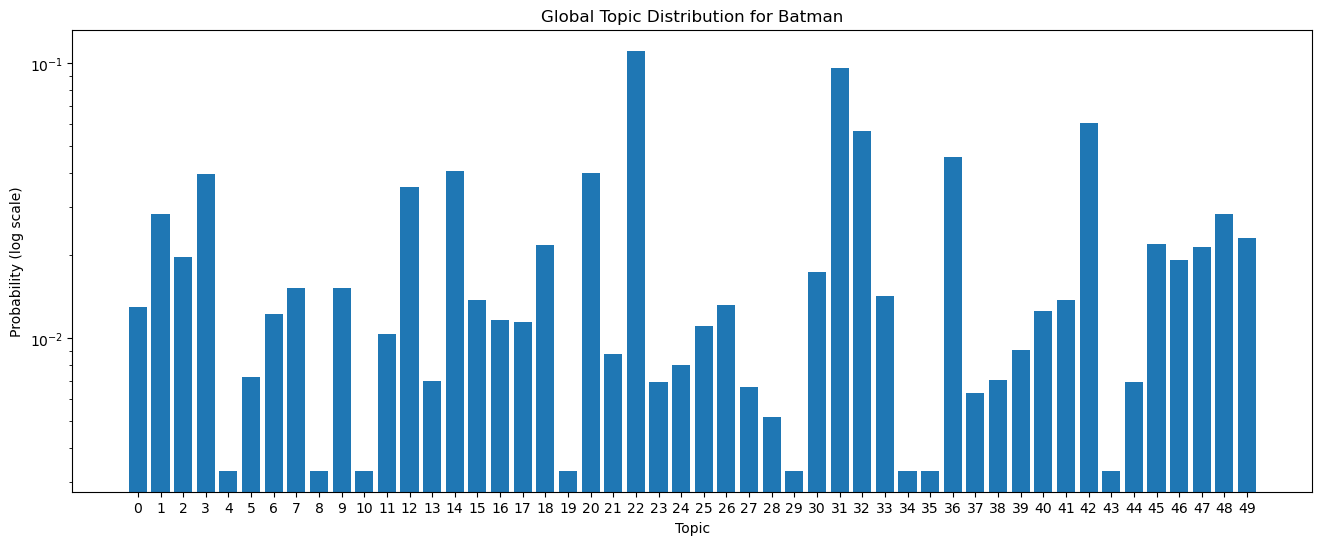

In [91]:
# show the global topic distribution for a character (all movies containing this character)
character='Batman'

# Get the rows for same character name in different movies
filtered_rows = character_classification_df.loc[character_classification_df['character_name'] == character, 'topic_dist']
# Sum the arrays along axis=0
sum_result = np.sum(filtered_rows.values.tolist(), axis=0)
# Normalize the sum by dividing by the number of rows
character_topics = sum_result / len(filtered_rows)

topics = range(len(character_topics))

# Creating the plot
plt.figure(figsize=(16, 6))
plt.bar(topics, character_topics)
plt.xlabel('Topic')
plt.ylabel('Probability (log scale)')
plt.title(f'Global Topic Distribution for {character}')
plt.yscale('log')  
plt.xticks(topics)
plt.show()

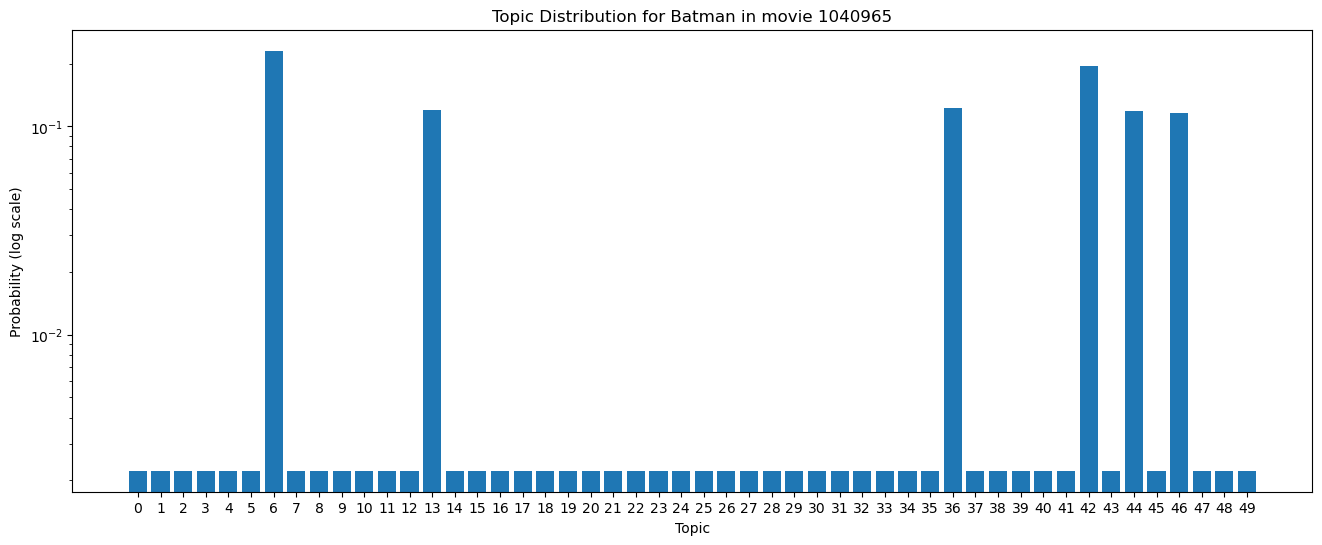

In [51]:
# show the topic distribution for a character (specific movie contain this character)
movie_id='1040965'
character='Batman'
movie_character=str(movie_id)+'_'+str(character)

character_topics = character_classification_df[character_classification_df['movieid_charactername'] == movie_character]['topic_dist'].iloc[0]

topics = range(len(character_topics))

# Creating the plot
plt.figure(figsize=(16, 6))
plt.bar(topics, character_topics)
plt.xlabel('Topic')
plt.ylabel('Probability (log scale)')
plt.title(f'Topic Distribution for {character} in movie {movie_id}')
plt.yscale('log')  
plt.xticks(topics)
plt.show()

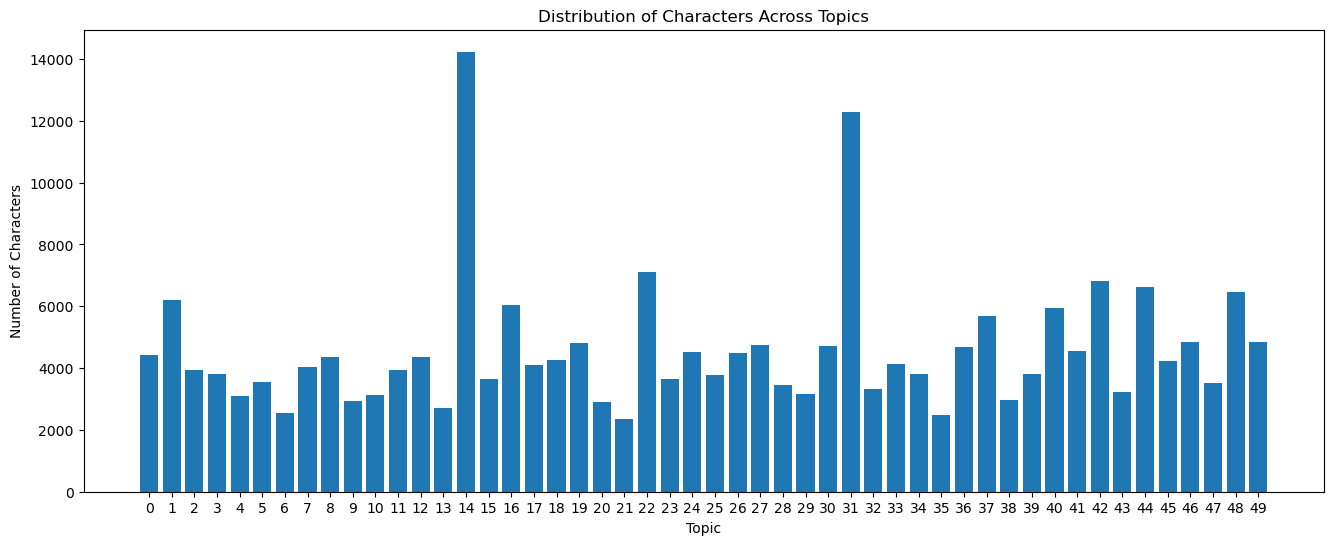

In [92]:
topic_counts = character_classification_df['topic'].value_counts()

topic_counts = topic_counts.sort_index()

plt.figure(figsize=(16, 6))
plt.bar(topic_counts.index, topic_counts.values)

plt.xlabel('Topic')
plt.ylabel('Number of Characters')
plt.title('Distribution of Characters Across Topics')
plt.xticks(topic_counts.index)
plt.show()

## Create a dataframe combine with director, movie and chracter type(topic)

In [2]:
cmu_characters = read_dataframe(name='cmu/characters', usecols=[
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie release date",
    "Character name",
    "Actor DOB",
    "Actor gender",
    "Actor height",
    "Actor ethnicity",
    "Actor name",
    "Actor age at movie release",
    "Freebase character/actor map ID",
    "Freebase character ID",
    "Freebase actor ID",
])

cmu_movies = read_dataframe(name='cmu/movies', usecols=[
    "Wikipedia movie ID", 
    "Freebase movie ID", 
    "Movie name", 
    "Movie release date", 
    "Movie box office revenue", 
    "Movie runtime", 
    "Movie languages", 
    "Movie countries", 
    "Movie genres",
])

In [3]:
# Merge the two dataframes to get a dataframe with the character name and the movie name
cmu_characters_movie = pd.merge(cmu_characters, cmu_movies, on=["Wikipedia movie ID", "Freebase movie ID"])
# Keep only the columns we need: "Wikipedia movie ID", "Freebase movie ID", "Movie name", "Character name"
cmu_characters_movie = cmu_characters_movie[["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Character name"]]
cmu_characters_movie.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Character name
0,975900,/m/03vyhn,Ghosts of Mars,Akooshay
1,975900,/m/03vyhn,Ghosts of Mars,Lieutenant Melanie Ballard
2,975900,/m/03vyhn,Ghosts of Mars,Desolation Williams


## Use imdb_crew

In [4]:
imdb_crew = read_dataframe(name='imdb/crew')
imdb_crew = imdb_crew[['tconst', 'directors']]
imdb_crew = imdb_crew[imdb_crew['directors'].notna()]
display(imdb_crew.head(3))
print(imdb_crew['directors'].unique())

,tconst,directors
0,tt0000001,nm0005690
1,tt0000002,nm0721526
2,tt0000003,nm0721526


In [5]:
# TODO: update mapping method using here, seems Sepher is updating now, now the one using is wp2imdb_02 (wrote in 2023/Dec/06)

mapping_02 = read_dataframe(name='mapping_freebase_imdb')

imdb_crew_exploded=imdb_crew.copy()
imdb_crew_exploded['directors'] = imdb_crew_exploded['directors'].str.split(',')
imdb_crew_exploded = imdb_crew_exploded.explode(['directors'])


merged_ipe = pd.merge(imdb_crew_exploded, mapping_02, how='inner', left_on='tconst', right_on='imdb')
merged_ipe.head(3)



,tconst,directors,freebase,imdb
0,tt0000001,nm0005690,/m/0kvdsy,tt0000001
1,tt0000002,nm0721526,/m/02pz844,tt0000002
2,tt0000003,nm0721526,/m/0g53g2,tt0000003


In [11]:
print(len(imdb_crew_exploded['directors'].unique()))

767490


In [12]:
matched_imdb_crew = merged_ipe.drop_duplicates(subset=['tconst','directors'], keep='first')

display(matched_imdb_crew.head(3))
print(len(matched_imdb_crew))
print(len(matched_imdb_crew['directors'].unique()))

,tconst,directors,freebase,imdb
0,tt0000001,nm0005690,/m/0kvdsy,tt0000001
1,tt0000002,nm0721526,/m/02pz844,tt0000002
2,tt0000003,nm0721526,/m/0g53g2,tt0000003


83927
28536


In [8]:
# Merge cmu_characters_movie and matched_imdb_crew on freebase movie id(left) and freebase(right)
cmu_characters_movie_imdb = pd.merge(cmu_characters_movie, matched_imdb_crew, how='inner', left_on=['Freebase movie ID'], right_on=['freebase'])
display(cmu_characters_movie_imdb.head(3))
print(len(cmu_characters_movie_imdb['directors'].unique()))


,Wikipedia movie ID,Freebase movie ID,Movie name,Character name,tconst,directors,freebase,imdb
0,975900,/m/03vyhn,Ghosts of Mars,Akooshay,tt0228333,nm0000118,/m/03vyhn,tt0228333
1,975900,/m/03vyhn,Ghosts of Mars,Lieutenant Melanie Ballard,tt0228333,nm0000118,/m/03vyhn,tt0228333
2,975900,/m/03vyhn,Ghosts of Mars,Desolation Williams,tt0228333,nm0000118,/m/03vyhn,tt0228333


22440


In [51]:
character_classification_df=pd.read_parquet('../generated/annotations_2023/character_classification_update.parquet', engine='pyarrow')
character_classification_df.head(3)

,movieid_charactername,topic,topic_dist,movie_id,character_name
0,11784534_Ingrid Bergman,22,"[0.00666666666666941, 0.00666666666666941, 0.0...",11784534,Ingrid Bergman
1,11784534_George Sanders,10,"[0.0066666666666673775, 0.0066666666666673775,...",11784534,George Sanders
2,10131263_Wile E. Coyote,23,"[0.004000000000000387, 0.004000000000000387, 0...",10131263,Wile E. Coyote


In [52]:
character_movie_directors = pd.merge(cmu_characters_movie_imdb, character_classification_df, how='inner', left_on=['Wikipedia movie ID','Character name'], right_on=['movie_id','character_name'])
character_movie_directors.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Character name,tconst,directors,freebase,imdb,movieid_charactername,topic,topic_dist,movie_id,character_name
0,2238856,/m/06yc6v,Me and You and Everyone We Know,Andrew,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Andrew,26,"[0.01000000000000015, 0.01000000000000015, 0.0...",2238856,Andrew
1,2238856,/m/06yc6v,Me and You and Everyone We Know,Heather,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Heather,31,"[0.245870487647632, 0.005000000000000419, 0.00...",2238856,Heather
2,2238856,/m/06yc6v,Me and You and Everyone We Know,Pam,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Pam,30,"[0.010000000000000016, 0.010000000000000016, 0...",2238856,Pam


In [53]:
# Get rid of the columns we don't need: movie_id, character_name
character_movie_directors = character_movie_directors.drop(columns=['movie_id', 'character_name'])
character_movie_directors.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Character name,tconst,directors,freebase,imdb,movieid_charactername,topic,topic_dist
0,2238856,/m/06yc6v,Me and You and Everyone We Know,Andrew,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Andrew,26,"[0.01000000000000015, 0.01000000000000015, 0.0..."
1,2238856,/m/06yc6v,Me and You and Everyone We Know,Heather,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Heather,31,"[0.245870487647632, 0.005000000000000419, 0.00..."
2,2238856,/m/06yc6v,Me and You and Everyone We Know,Pam,tt0415978,nm0432380,/m/06yc6v,tt0415978,2238856_Pam,30,"[0.010000000000000016, 0.010000000000000016, 0..."


In [54]:
character_movie_directors.to_parquet(os.path.join(DATA_PATH, "character_movie_directors.parquet"), compression= "brotli")

In [55]:
# An example to group by the directors
character_movie_directors_group = character_movie_directors.groupby('directors').agg({'Wikipedia movie ID': lambda x: list(x), 'Freebase movie ID': lambda x: list(x), 'Movie name': lambda x: list(x), 'Character name': lambda x: list(x), 'topic': lambda x: list(x), 'tconst': lambda x: list(x)})
character_movie_directors_group.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Character name,topic,tconst
directors,,,,,,
nm0000005,"[225554, 33124, 176545, 176545, 176545, 176545...","[/m/01gw6b, /m/08239, /m/017yv4, /m/017yv4, /m...","[Autumn Sonata, Wild Strawberries, The Seventh...","[Charlotte Andergast, Sara, Mia, Raval, Lisa, ...","[47, 40, 30, 30, 30, 15, 7, 31, 31, 48, 36]","[tt0077711, tt0050986, tt0050976, tt0050976, t..."
nm0000008,[418252],[/m/02616b],[One-Eyed Jacks],[Rio],[36],[tt0055257]
nm0000019,"[2339510, 2339510, 2339510, 3822528, 3822528, ...","[/m/074x3d, /m/074x3d, /m/074x3d, /m/0b1szl, /...","[La Strada, La Strada, La Strada, Satyricon, S...","[Gelsomina, Zampanò, Il Matto, Gitone, Encolpi...","[14, 3, 45, 6, 48, 32, 41, 30, 30, 15, 22, 37,...","[tt0047528, tt0047528, tt0047528, tt0064940, t..."


In [56]:
character_movie_directors_group.shape

(6941, 6)

## Use imdb principle

In [ ]:
imdb_people = read_dataframe(name='imdb/names')
imdb_principals = read_dataframe(name='imdb/principals')

In [ ]:
mapping_02 = read_dataframe(name='mapping_freebase_imdb')
imdb_people_exploded = imdb_people.copy()
imdb_people_exploded['knownForTitles'] = imdb_people['knownForTitles'].str.split(',')
imdb_people_exploded = imdb_people_exploded.explode(['knownForTitles'])


merged_ipe = pd.merge(imdb_people_exploded, mapping_02, how='inner', left_on='knownForTitles', right_on='imdb')
unique_matched_persons = merged_ipe.drop_duplicates(subset='nconst', keep='first')

matched_imdb_people = pd.merge(imdb_people, unique_matched_persons[['nconst']], on='nconst', how='inner')
len(matched_imdb_people)

In [6]:
# !pip install memory_profiler
# install and load memory_profiler to use %memit, use %whos to see what's in memory
%reload_ext memory_profiler
%memit
import gc

del imdb_people
del imdb_principals
del imdb_people_exploded
del imdb_crew
del imdb_crew_exploded
# del imdb_crew
# del bags_df
# del lda


gc.collect()
%memit

peak memory: 12953.04 MiB, increment: 0.69 MiB
peak memory: 10008.68 MiB, increment: 0.00 MiB


In [5]:
tmp_principal_people = pd.merge(imdb_principals, matched_imdb_people[['nconst']], on='nconst', how='inner')
matched_principal_people = pd.merge(tmp_principal_people,mapping_02[['imdb']],left_on='tconst',right_on='imdb',how='inner')
display(matched_principal_people)
print(matched_principal_people['nconst'].nunique())
print(matched_principal_people['tconst'].nunique())

,tconst,ordering,nconst,category,job,characters,imdb
0,tt0000001,1,nm1588970,self,<NA>,"[""Self""]",tt0000001
1,tt0000001,3,nm0374658,cinematographer,director of photography,<NA>,tt0000001
2,tt0000007,4,nm0374658,director,<NA>,<NA>,tt0000007
3,tt0000007,5,nm0249379,producer,producer,<NA>,tt0000007
4,tt0000007,1,nm0179163,actor,<NA>,<NA>,tt0000007
...,...,...,...,...,...,...,...
618720,tt7078616,8,nm9098080,production_designer,<NA>,<NA>,tt7078616
618721,tt8355792,1,nm5533542,director,<NA>,<NA>,tt8355792
618722,tt8355792,2,nm9808822,director,<NA>,<NA>,tt8355792
618723,tt9455528,10,nm10334425,actor,<NA>,<NA>,tt9455528


191563
73646


In [13]:
directors_df = matched_principal_people[matched_principal_people['category'] == 'director']
directors_df.head(3)

,tconst,ordering,nconst,category,job,characters,imdb
2,tt0000007,4,nm0374658,director,<NA>,<NA>,tt0000007
8,tt0000038,4,nm0374658,director,<NA>,<NA>,tt0000038
15,tt0139738,3,nm0374658,director,<NA>,<NA>,tt0139738


In [19]:
directors_df=directors_df[['tconst','nconst','imdb','category']]
directors_df.head(3)

,tconst,nconst,imdb,category
2,tt0000007,nm0374658,tt0000007,director
8,tt0000038,nm0374658,tt0000038,director
15,tt0139738,nm0374658,tt0139738,director


In [30]:
matched_directors_df=pd.merge(directors_df, mapping_02[['imdb','freebase']], on='imdb', how='inner')
# rename colum nconst to directors
matched_directors_df.rename(columns={'nconst':'directors'}, inplace=True)
matched_directors_df.head(3)

,tconst,director,imdb,category,freebase
0,tt0000007,nm0374658,tt0000007,director,/m/02q1zd3
1,tt0000038,nm0374658,tt0000038,director,/m/02rd7zz
2,tt0139738,nm0374658,tt0139738,director,/m/028bhr


In [27]:
cmu_characters_movie.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Character name
0,975900,/m/03vyhn,Ghosts of Mars,Akooshay
1,975900,/m/03vyhn,Ghosts of Mars,Lieutenant Melanie Ballard
2,975900,/m/03vyhn,Ghosts of Mars,Desolation Williams


In [36]:
# Merge cmu_characters_movie and matched_imdb_crew on freebase movie id(left) and freebase(right)
cmu_characters_movie_imdb = pd.merge(cmu_characters_movie[['Wikipedia movie ID','Freebase movie ID','Movie name','Character name']], matched_directors_df[['tconst','directors','freebase','imdb']], how='inner', left_on=['Freebase movie ID'], right_on=['freebase'])
cmu_characters_movie_imdb.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Character name,tconst,director,freebase,imdb
0,975900,/m/03vyhn,Ghosts of Mars,Akooshay,tt0228333,nm0000118,/m/03vyhn,tt0228333
1,975900,/m/03vyhn,Ghosts of Mars,Lieutenant Melanie Ballard,tt0228333,nm0000118,/m/03vyhn,tt0228333
2,975900,/m/03vyhn,Ghosts of Mars,Desolation Williams,tt0228333,nm0000118,/m/03vyhn,tt0228333


In [37]:
len(cmu_characters_movie_imdb['directors'].unique())

17649

In [38]:
character_classification_df=pd.read_parquet('../generated/annotations_2023/character_classification_update.parquet', engine='pyarrow')
character_classification_df.head(3)

,movieid_charactername,topic,topic_dist,movie_id,character_name
0,11784534_Ingrid Bergman,22,"[0.00666666666666941, 0.00666666666666941, 0.0...",11784534,Ingrid Bergman
1,11784534_George Sanders,10,"[0.0066666666666673775, 0.0066666666666673775,...",11784534,George Sanders
2,10131263_Wile E. Coyote,23,"[0.004000000000000387, 0.004000000000000387, 0...",10131263,Wile E. Coyote


In [39]:
character_movie_directors = pd.merge(cmu_characters_movie_imdb, character_classification_df, how='inner', left_on=['Wikipedia movie ID','Character name'], right_on=['movie_id','character_name'])
character_movie_directors.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Character name,tconst,director,freebase,imdb,movieid_charactername,topic,topic_dist,movie_id,character_name
0,156558,/m/014k4y,Baby Boy,Yvette,tt0255819,nm0005436,/m/014k4y,tt0255819,156558_Yvette,31,"[0.0012500000000002947, 0.0012500000000002947,...",156558,Yvette
1,156558,/m/014k4y,Baby Boy,Jody,tt0255819,nm0005436,/m/014k4y,tt0255819,156558_Jody,31,"[0.0008695652173914489, 0.0008695652173914489,...",156558,Jody
2,156558,/m/014k4y,Baby Boy,Rodney,tt0255819,nm0005436,/m/014k4y,tt0255819,156558_Rodney,42,"[0.0014285714285728847, 0.0014285714285728847,...",156558,Rodney


In [40]:
len(character_movie_directors['director'].unique())

6005